# **Proyecto Final MeIA. Segmentación Semántica con dataset HAGDAVS**

In [48]:
%%capture
!pip uninstall tensorflow -y
!pip uninstall tensorflow-io -y
!pip install tensorflow
!pip install --no-deps tensorflow-io

# *Carga de librerías*


In [49]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import pathlib
from PIL import Image
import shutil
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.data import AUTOTUNE

## **Load Data**

In [50]:
data_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = data_dir / 'RGB'
masks_dir = data_dir / 'MASK'

folder_path = masks_dir  # Ruta de la carpeta que contiene las imágenes
new_folder_path = '/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS/MASK'

# Crear la nueva carpeta si no existe
os.makedirs(new_folder_path, exist_ok=True)

# Obtener la lista de nombres de archivo en la carpeta
file_list = os.listdir(folder_path)

# Aplicar la modificación del nombre y crear nuevos archivos en la nueva carpeta
for filename in file_list:
    if "MClass" in filename:
        new_filename = filename.replace("MClass", "RGB")
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(new_folder_path, new_filename)
        shutil.copy2(old_path, new_path)

In [51]:
import tensorflow as tf
import tensorflow_io as tfio
import pathlib

# Ruta a las carpetas de imágenes y máscaras
ima_dir = pathlib.Path('/kaggle/input/hagdavs/HAGDAVS')
images_dir = ima_dir / 'RGB'
m_dir = pathlib.Path('/kaggle/working/semantic-segmentation-hagdavs/HAGDAVS')
mask_dir = m_dir / 'MASK'

# Obtener una lista de rutas de archivo para imágenes y máscaras
image_paths = sorted([str(path) for path in images_dir.glob('*.tif')])
mask_paths = sorted([str(path) for path in mask_dir.glob('*.tif')])

# Crear una lista para almacenar los parches de imágenes y máscaras
image_patches = []
mask_patches = []

# Tamaño del parche deseado
patch_size = (256, 256)


# Definir una función para cargar y dividir las imágenes y máscaras en parches
def load_and_split_patches(image_path, mask_path):
    image = tfio.experimental.image.decode_tiff(tf.io.read_file(image_path))
    mask = tfio.experimental.image.decode_tiff(tf.io.read_file(mask_path))

    # Eliminar el canal alfa de las imágenes y máscaras
    image = image[:, :, :3]
    mask = mask[:, :, :3]

    # Dividir la imagen en parches
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch_image = image[i:i+patch_size[0], j:j+patch_size[1], :]
            patch_mask = mask[i:i+patch_size[0], j:j+patch_size[1], :]

            # Verificar si todos los píxeles en el parche de la máscara son negros
            if tf.reduce_all(tf.math.equal(patch_mask, [0, 0, 0])):
                continue
                
            #patch_mask = convertir_colores(patch_mask)
            image_patches.append(patch_image)
            mask_patches.append(patch_mask)

    return None

# Aplicar la función de carga y división de parches a cada par de rutas de archivo
for image_path, mask_path in zip(image_paths, mask_paths):
    load_and_split_patches(image_path, mask_path)

# Convertir las listas de parches en tensores
image_patches = tf.convert_to_tensor(image_patches)
mask_patches = tf.convert_to_tensor(mask_patches)




In [52]:

print(len(image_patches))
print(len(mask_patches))
print(type(image_patches[0]))


1316
1316
<class 'tensorflow.python.framework.ops.EagerTensor'>


# Se imprimen unas imagenes para conocer el dataset

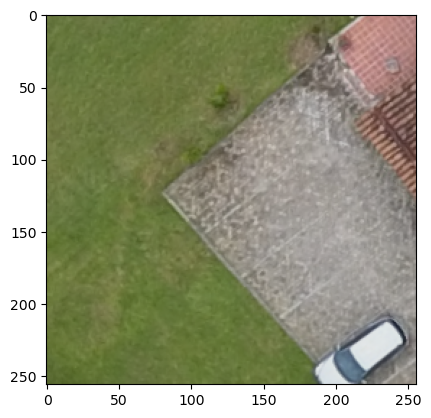

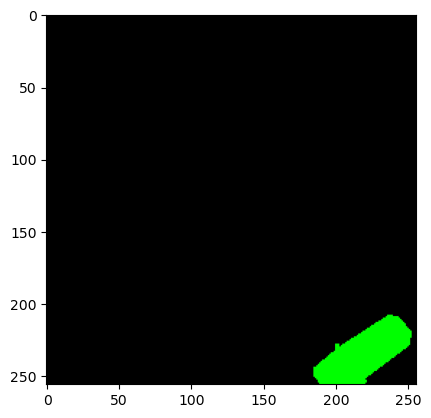

In [53]:
import matplotlib.pyplot as plt
imagen=image_patches[-2]
mask=mask_patches[-2]
plt.imshow(imagen)
plt.show()
plt.imshow(mask)
plt.show()


# Aumento de Datos

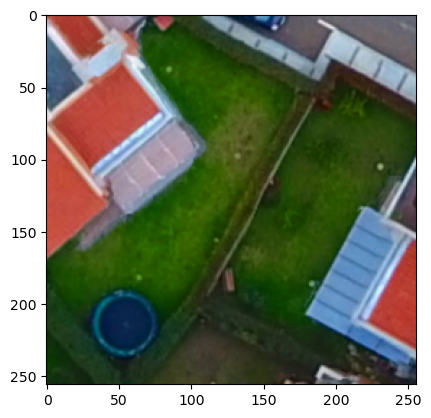

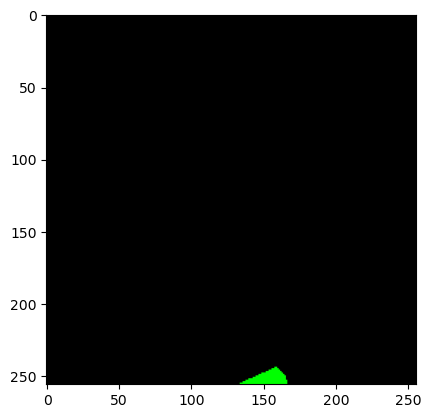

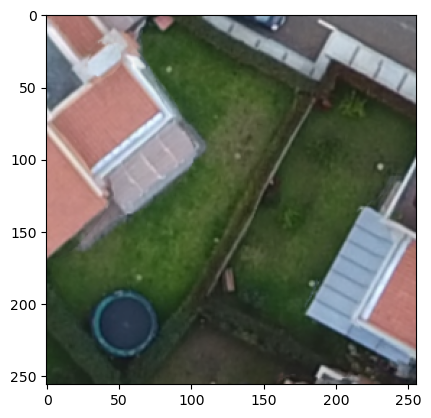

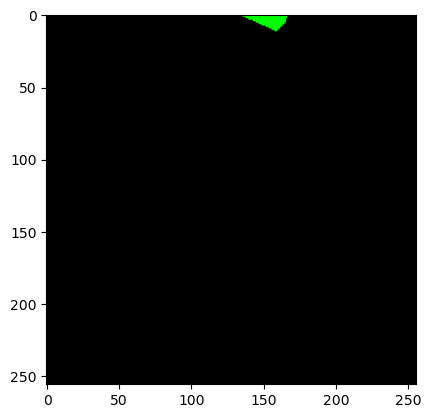

2016
2016


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

exp_img=image_patches[:700]
exp_mask=mask_patches[:700]


data_augmentation = tf.keras.Sequential([
  layers.Rescaling(1.0 / 255.0),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.Lambda(lambda x: tf.image.adjust_saturation(x, 2.0))
])


img_transf = []
mask_transf = []

for imagen, mascara in zip(exp_img, exp_mask):
    imagen_transformada = data_augmentation(tf.expand_dims(imagen, axis=0))[0]
    mascara_transformada = data_augmentation(tf.expand_dims(mascara, axis=0))[0]
    img_transf.append(imagen_transformada)
    mask_transf.append(mascara_transformada)

plt.imshow(img_transf[0])
plt.show()
plt.imshow(mask_transf[0])
plt.show()
plt.imshow(image_patches[0])
plt.show()
plt.imshow(mask_patches[0])
plt.show()

image_patches=tf.concat([image_patches,img_transf],axis=0)
mask_patches=tf.concat([mask_patches,mask_transf],axis=0)
    
print(len(image_patches))
print(len(mask_patches))

In [55]:
dataset = tf.data.Dataset.from_tensor_slices((image_patches, mask_patches))
print(len(dataset))

2016


## **Display Data**

Function for show the image, mask and prediction mask

In [56]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

## **Using only one class**

In [57]:
def convertir_mascara(mascara):
    mascara = tf.cast(mascara, dtype=tf.float32)
    mascara_convertida = tf.zeros((256, 256, 1), dtype=tf.float32)

    # Asigna valores correspondientes a cada clase
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [255, 0, 0]), axis=-1, keepdims=True), 0.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 255, 0]), axis=-1, keepdims=True), 1.0, mascara_convertida)
    mascara_convertida = tf.where(tf.reduce_all(tf.equal(mascara, [0, 0, 255]), axis=-1, keepdims=True), 0.0, mascara_convertida)

    return mascara_convertida

mapped_dataset = dataset.map(lambda x, y: (x, convertir_mascara(y)))

In [58]:
import tensorflow as tf

def filter_func(image, mask):
    unique_classes = tf.unique(tf.reshape(mask, [-1]))[0]
    return tf.size(unique_classes) >= 2

filtered_dataset = mapped_dataset.filter(filter_func)

dataset_length = 0
for _ in filtered_dataset:
    dataset_length += 1

print("Longitud aproximada del dataset filtrado:", dataset_length)

Longitud aproximada del dataset filtrado: 1043


## **Splitting data**

train/test/val split

In [59]:
# dividir el dataset en conjuntos de entrenamiento, validación y prueba
total_samples = (dataset_length)
train_size = int(0.80 * total_samples)
val_size = int(0.12 * total_samples)
test_size = total_samples - train_size - val_size

train_dataset = filtered_dataset.take(train_size)
val_dataset = filtered_dataset.skip(train_size).take(val_size)
test_dataset = filtered_dataset.skip(train_size + val_size).take(test_size)

In [60]:
BATCH_SIZE = 16
BUFFER_SIZE = 100

In [61]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

## **Unet**

In [62]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
        

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", kernel_initializer = "he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # dropout
    x = layers.Dropout(0.18)(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.21)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.22)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x
    
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(256,256,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    bottleneck = layers.Dropout(0.33)(bottleneck)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

#loss = keras.losses.sparse_categorical_crossentropy()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss='binary_crossentropy',
                   metrics=["accuracy"])

## **Training**

In [63]:
keras.backend.clear_session()
NUM_EPOCHS = 10
BATCH_SIZE = 16


STEPS_PER_EPOCH = total_samples // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,)

Epoch 1/10


2023-06-29 01:12:21.967221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


65/65 [==============================] - 89s 945ms/step - loss: 0.1931 - accuracy: 0.9418 - val_loss: 2566.2549 - val_accuracy: 0.0852
Epoch 2/10
65/65 [==============================] - 62s 958ms/step - loss: 0.1103 - accuracy: 0.9669 - val_loss: 49.9885 - val_accuracy: 0.5574
Epoch 3/10
65/65 [==============================] - 60s 923ms/step - loss: 0.1063 - accuracy: 0.9640 - val_loss: 17.7297 - val_accuracy: 0.2733
Epoch 4/10
65/65 [==============================] - 62s 958ms/step - loss: 0.0955 - accuracy: 0.9652 - val_loss: 0.1795 - val_accuracy: 0.9121
Epoch 5/10
65/65 [==============================] - 60s 924ms/step - loss: 0.0879 - accuracy: 0.9680 - val_loss: 0.1328 - val_accuracy: 0.9517
Epoch 6/10
65/65 [==============================] - 61s 934ms/step - loss: 0.0795 - accuracy: 0.9714 - val_loss: 0.1071 - val_accuracy: 0.9467
Epoch 7/10
65/65 [==============================] - 62s 958ms/step - loss: 0.0789 - accuracy: 0.9716 - val_loss: 1.0352 - val_accuracy: 0.5591
Epoch

## **Visualization of predictions**

In [64]:
def create_mask(pred_mask, threshold=0.2):
  pred_mask = tf.cast(pred_mask, dtype=tf.float32)  # convertir a float
  pred_mask = tf.where(pred_mask > threshold, 1.0, 0.0)  # usar float para el threshold
  return pred_mask[0]

def show_predictions(dataset, model, num):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 623ms/step


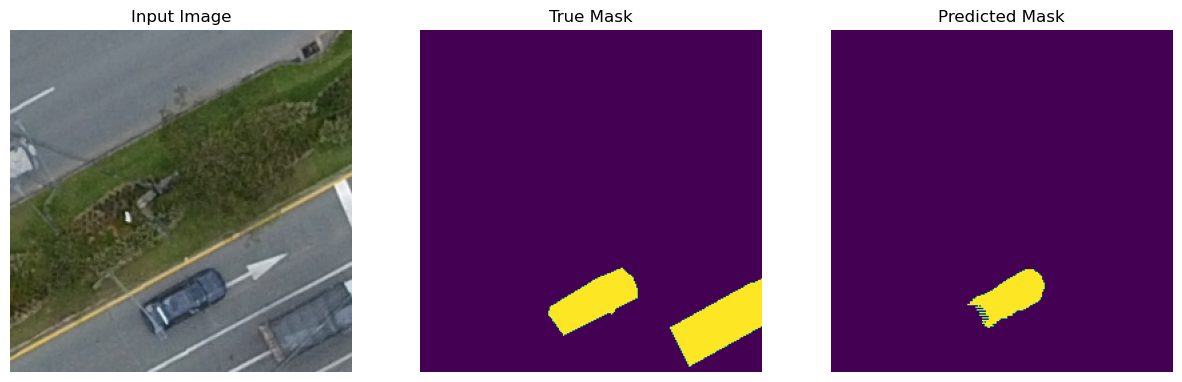

1/1 [==============================] - 0s 57ms/step


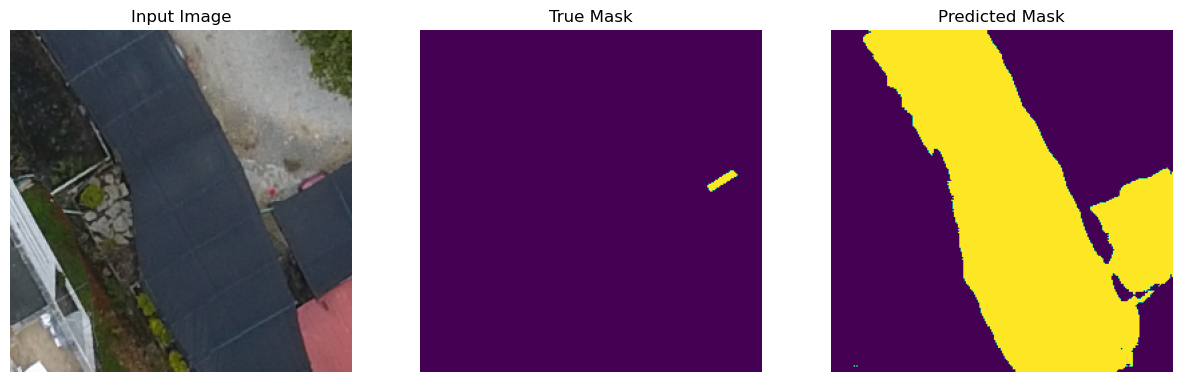

1/1 [==============================] - 0s 52ms/step


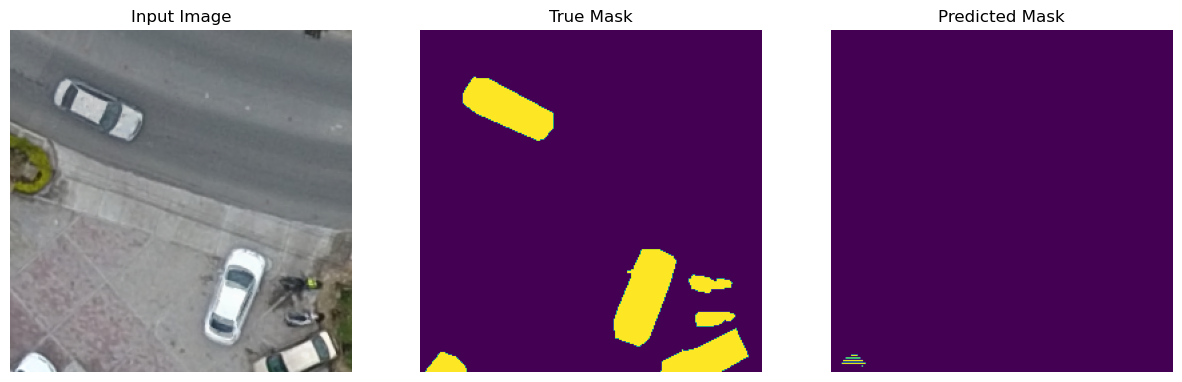

1/1 [==============================] - 0s 60ms/step


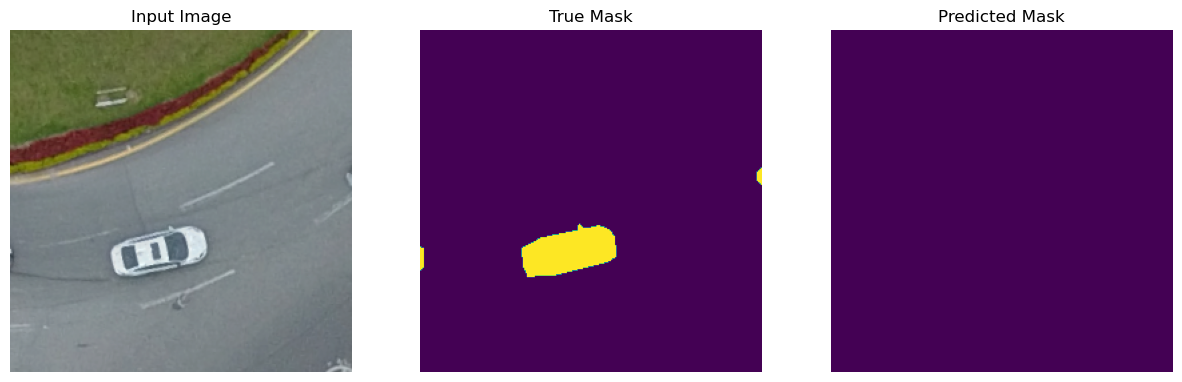

1/1 [==============================] - 0s 24ms/step


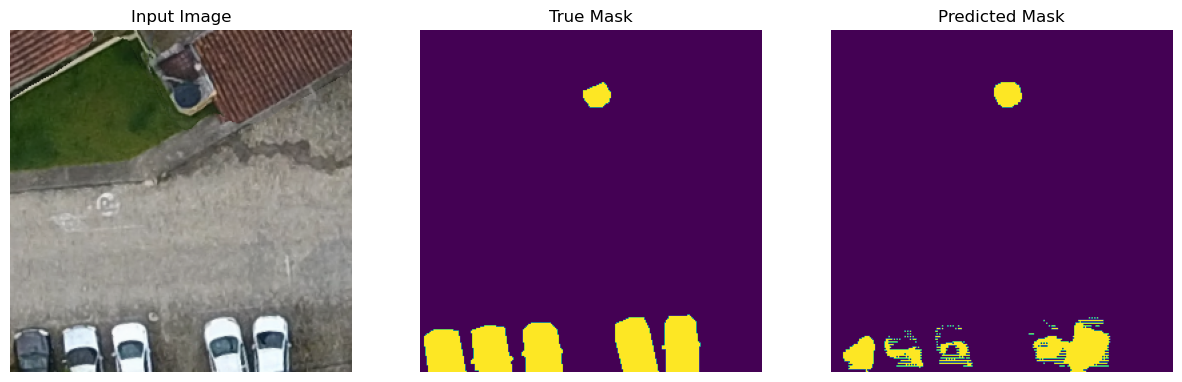

1/1 [==============================] - 2s 2s/step


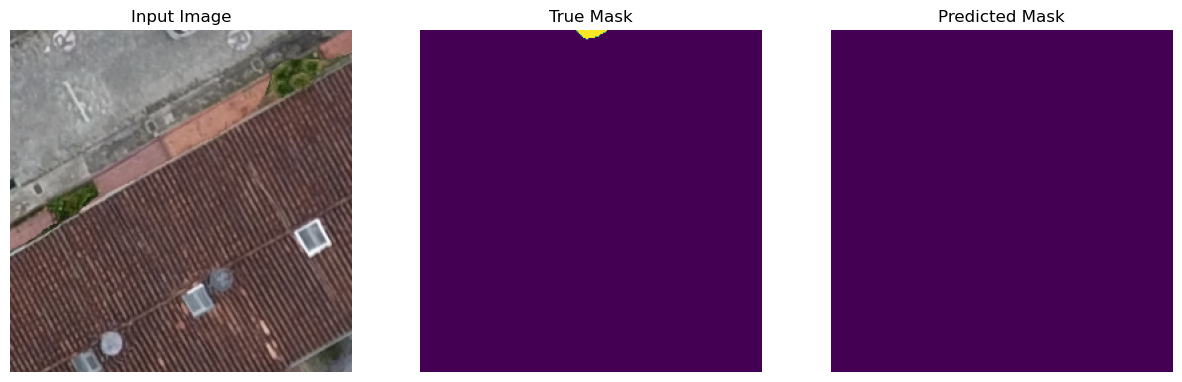

In [65]:
show_predictions(test_batches, unet_model, 16)